# **Using Dice loss only**
# Plotting and inference

In [1]:
!pip install "protobuf<5" -q

In [2]:
!pip install monai-weekly --no-deps -q
!pip install einops -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import gc
import cv2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import nibabel as nib
import csv
import time 
from datetime import datetime
import warnings
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from monai.networks.nets import UNet
from monai.metrics import HausdorffDistanceMetric
from monai.transforms import AsDiscrete
from monai.losses import DiceLoss

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-02 14:43:59.591090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764686639.779734      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764686639.836111      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
class Config:

    train_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr'
    labels_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr'
    outputs_dir = "/kaggle/working/outputs"

    vol_paths = list()
    seg_paths = list()

    n_classes = 1
    vols_count = None
    segs_count = None

    window = (-30,140)

    num_epochs = 40
    batch_size = 16
    lr = 0.0001

    height, width = 256, 256
    
config = Config()

In [7]:
for file in os.listdir(Config.train_dir):
    if file.endswith('.nii'):

        Config.vol_paths.append(os.path.join(Config.train_dir,file))
        Config.seg_paths.append(os.path.join(Config.labels_dir,file))

Config.vols_count = len(Config.vol_paths)
Config.segs_count = len(Config.seg_paths)

print('Total CT Scan Volumes for Train:', Config.vols_count)
print('Total Segmentation masks:', Config.segs_count)

Total CT Scan Volumes for Train: 123
Total Segmentation masks: 123


In [8]:
path = Config.vol_paths[1]
data = nib.load(path).get_fdata().transpose(2,1,0)
seg = nib.load(Config.seg_paths[1]).get_fdata().transpose(2,1,0)

In [9]:
seg.shape

(183, 210, 210)

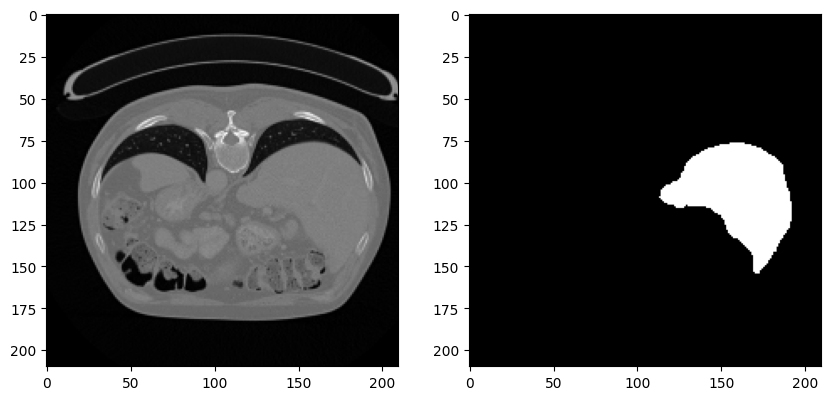

In [10]:
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(seg[150], cmap = 'gray')
plt.show()

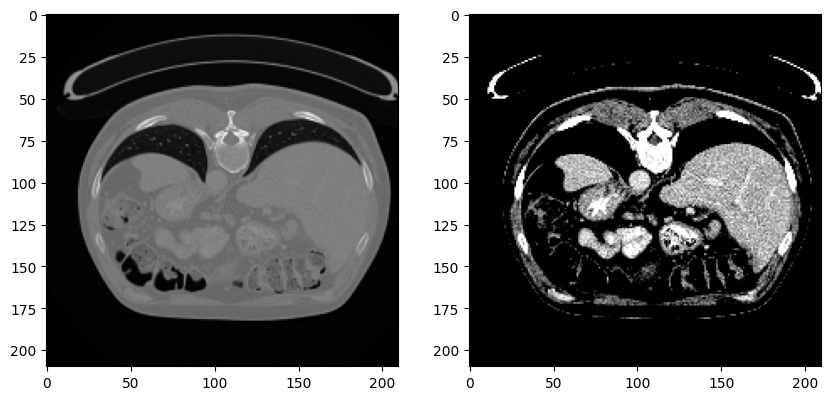

In [11]:
win_img = np.clip(data[150], -30,140)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

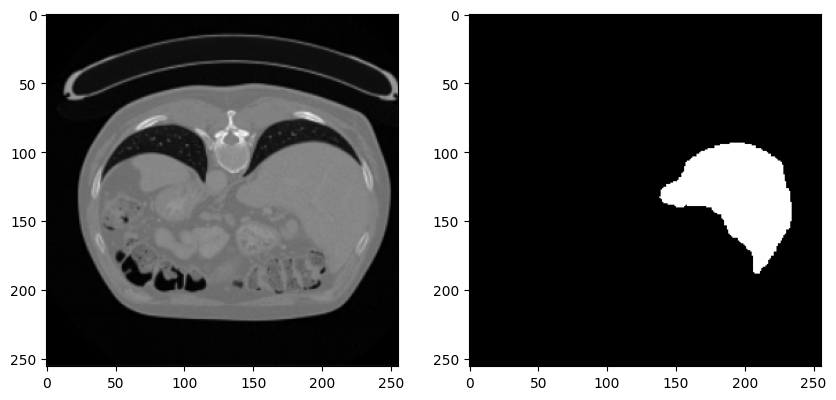

In [12]:
resized_X = resize(data[150], (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
resized_Y = resize(seg[150], (256, 256), mode='constant', preserve_range=True, order=0)

_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(resized_X, cmap = 'gray')
axes[1].imshow(resized_Y, cmap = 'gray')
plt.show()

In [13]:
def preprocess(ct_scan: np.ndarray, window: tuple = Config.window) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    # Apply windowing
    windowed_ct = np.clip(ct_scan, min_value, max_value)

    # Normalize to 0-1
    windowed_ct = ((windowed_ct - min_value) / (max_value - min_value))

    return windowed_ct

In [14]:
height, width = Config.height, Config.width
train_transform = A.Compose([
    A.Resize(height=height, width=width,interpolation=cv2.INTER_LINEAR, mask_interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.20, p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),


], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(height=Config.height, width=Config.width)
])

In [15]:
dataset = None

if dataset is not None:
    dataset = pd.DataFrame(dataset, columns = ['slice_idx', 'liver_mask_exists', 'vol_path', 'seg_path'])
    dataset.to_csv('liver-path-data.csv', index= False)
else:
    dataset = pd.read_csv('/kaggle/input/liver-path-data/liver-path-data.csv')
dataset.head()

,slice_idx,liver_mask_exists,vol_path,seg_path
0,0,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
1,1,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
2,2,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
3,3,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
4,4,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...


In [16]:
print("Total CT slices: ", len(dataset))
print("Slices with Liver: ", sum(dataset.liver_mask_exists))

Total CT slices:  19604
Slices with Liver:  6413


In [17]:
class LiverDataset(Dataset):
    def __init__(self, data, transform=None, preprocess_fn=None):
        self.slice_data = data
        self.transform = transform
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):

        slice_idx, _, vol_path, seg_path = self.slice_data.iloc[idx]

        # Load volume and mask
        vol = nib.load(vol_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        # Extract slice
        X = vol[:, :, slice_idx].transpose(1,0)
        Y = (seg[:, :, slice_idx].transpose(1,0) > 0).astype(np.float32)

        # 1. Apply your windowing + normalization
        if self.preprocess_fn:
            X = self.preprocess_fn(X)

        # 2. Albumentations expects HWC
        X = np.expand_dims(X, axis=-1)
        Y = np.expand_dims(Y, axis=-1)

        # 3. Augmentation (train) or Resize only (val)
        if self.transform:
            augmented = self.transform(image=X, mask=Y)
            X = augmented["image"]
            Y = augmented["mask"]

        # 4. Convert to CHW
        X = np.transpose(X, (2,0,1))
        Y = np.transpose(Y, (2,0,1))

        # 5. To torch
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()

        return X, Y

In [18]:
train, test = train_test_split(dataset,test_size=0.3, random_state=42, stratify=dataset.liver_mask_exists)


train_dataset = LiverDataset(train, transform=train_transform, preprocess_fn=preprocess)
val_dataset = LiverDataset(test,transform=val_transform, preprocess_fn=preprocess)


train_dataloader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True,num_workers=4, pin_memory=True )
val_dataloader   = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers = 2, pin_memory = True)


Displaying 5 raw vs processed samples...



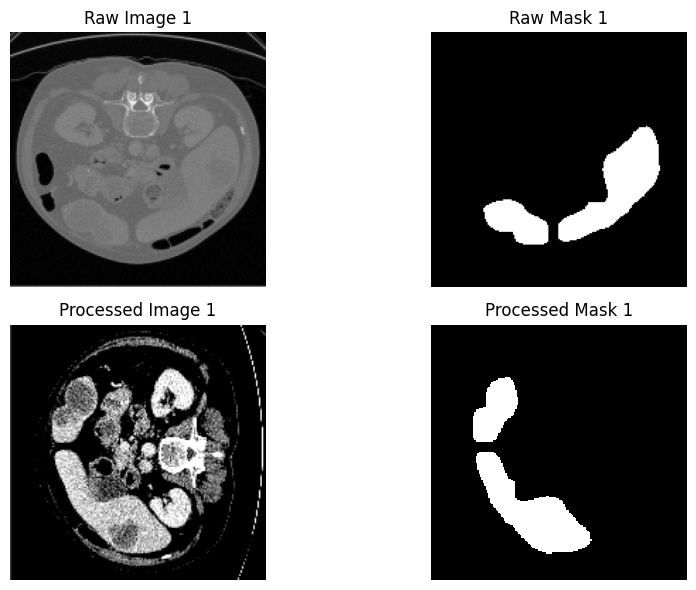

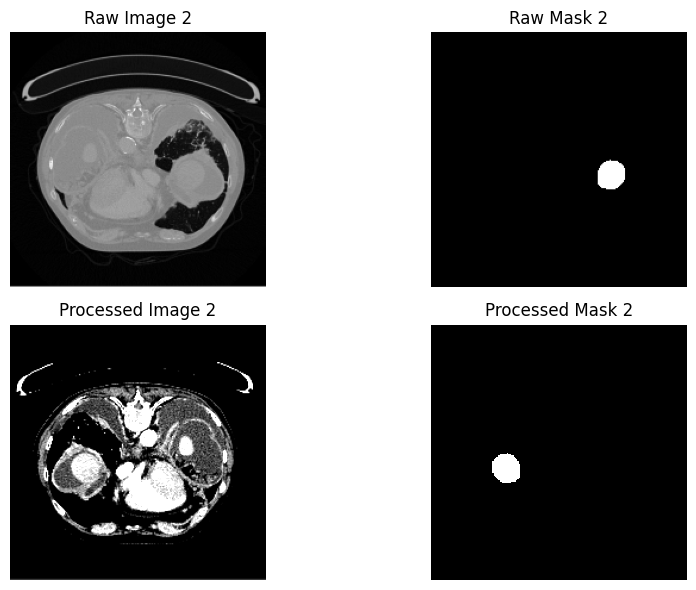

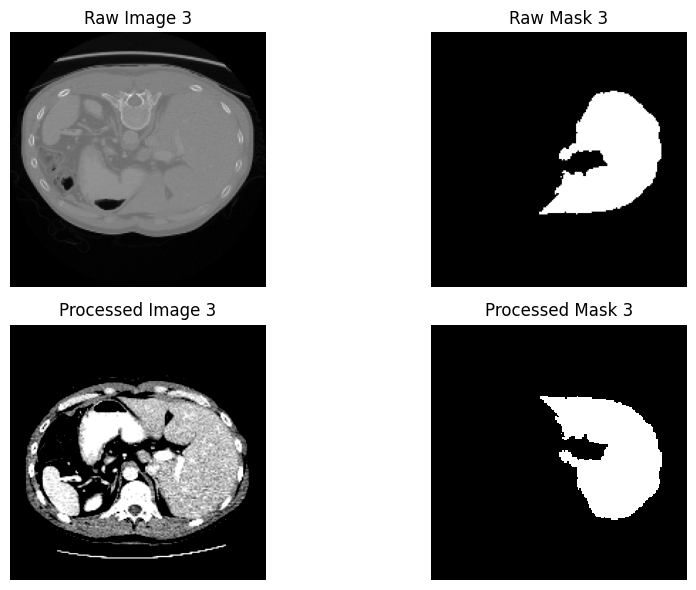

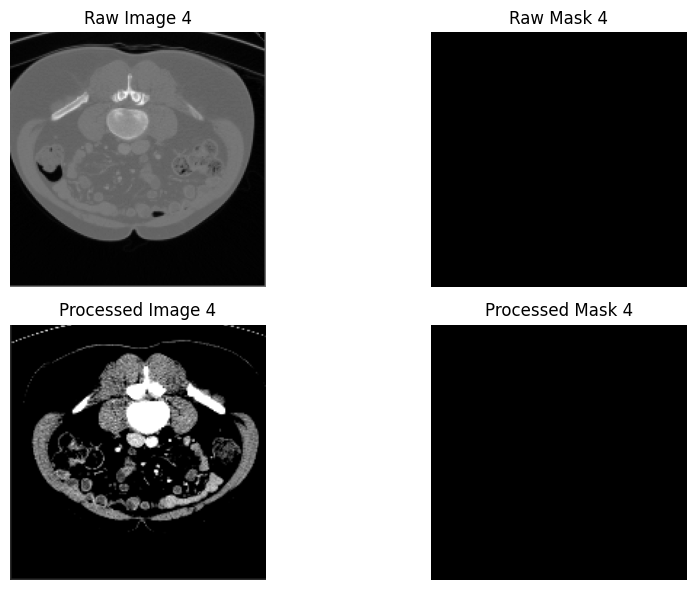

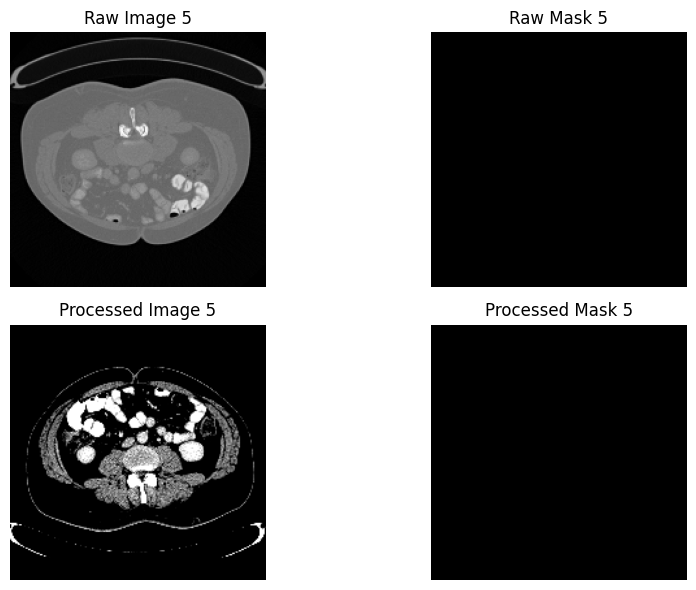

In [19]:
#Visulaize the effect of pre-processing 

def load_raw_slice(sample_row):
    slice_idx, _, vol_path, seg_path = sample_row

    # Load volume and segmentation
    vol = nib.load(vol_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    # Extract 2D slice
    X_raw = vol[:, :, slice_idx].transpose(1, 0)
    Y_raw = (seg[:, :, slice_idx].transpose(1, 0) > 0).astype(np.float32)

    return X_raw, Y_raw

def visualize_sample(raw_img, raw_mask, proc_img, proc_mask, index):
    plt.figure(figsize=(10, 6))

    # Raw Image
    plt.subplot(2, 2, 1)
    plt.imshow(raw_img, cmap='gray')
    plt.title(f"Raw Image {index}")
    plt.axis("off")

    # Raw Mask
    plt.subplot(2, 2, 2)
    plt.imshow(raw_mask, cmap='gray')
    plt.title(f"Raw Mask {index}")
    plt.axis("off")

    # Processed (augmented) Image
    plt.subplot(2, 2, 3)
    plt.imshow(proc_img.squeeze(), cmap='gray')
    plt.title(f"Processed Image {index}")
    plt.axis("off")

    # Processed (augmented) Mask
    plt.subplot(2, 2, 4)
    plt.imshow(proc_mask.squeeze(), cmap='gray')
    plt.title(f"Processed Mask {index}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

num_samples = 5
print("\nDisplaying 5 raw vs processed samples...\n")

for i in range(num_samples):
    # Get the i-th row from your training dataframe
    sample_row = train.iloc[i]

    # ---- 1. RAW DATA ----
    raw_img, raw_mask = load_raw_slice(sample_row)

    # ---- 2. PROCESSED (preprocessed + augmented) ----
    proc_img, proc_mask = train_dataset[i]   # returns CHW tensors

    # Convert processed images to numpy & HWC
    proc_img = proc_img.numpy().transpose(1, 2, 0)
    proc_mask = proc_mask.numpy().transpose(1, 2, 0)

    # ---- VISUALIZE ----
    visualize_sample(raw_img, raw_mask, proc_img, proc_mask, i+1)

In [20]:
from monai.networks.nets import UNet

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2,2,2,2),
    num_res_units=2,
    act='PRELU',
    norm='INSTANCE',
    dropout=0.0,
    bias=True,
    adn_ordering='NDA'
).to(device)

In [21]:
from torchinfo import summary
summary(model, input_size=(1, 1, 256, 256), col_names=("input_size","output_size","num_params","trainable"), device=str(device))

Layer (type:depth-idx)                                                                     Input Shape               Output Shape              Param #                   Trainable
UNet                                                                                       [1, 1, 256, 256]          [1, 1, 256, 256]          --                        True
├─Sequential: 1-1                                                                          [1, 1, 256, 256]          [1, 1, 256, 256]          --                        True
│    └─ResidualUnit: 2-1                                                                   [1, 1, 256, 256]          [1, 32, 128, 128]         --                        True
│    │    └─Conv2d: 3-1                                                                    [1, 1, 256, 256]          [1, 32, 128, 128]         320                       True
│    │    └─Sequential: 3-2                                                                [1, 1, 256, 256]          [1, 32, 

In [22]:
def compute_metrics(outputs, targets, threshold=0.5, eps=1e-7):
    """
    Returns soft-thresholded Dice, IoU, Precision, Recall (floats).
    outputs: raw logits (Tensor Bx1xHxW)
    targets: binary masks  (Tensor Bx1xHxW)
    """
    probs       = torch.sigmoid(outputs)
    preds       = (probs > threshold).float()
    t_flat      = targets.view(targets.size(0), -1)
    p_flat      = preds.view(preds.size(0), -1)

    tp    = (p_flat * t_flat).sum(dim=1)
    fp    = p_flat.sum(dim=1) - tp
    fn    = t_flat.sum(dim=1) - tp

    dice  = (2*tp + eps) / (p_flat.sum(1) + t_flat.sum(1) + eps)
    iou   = (tp + eps)   / (p_flat.sum(1) + t_flat.sum(1) - tp + eps)
    prec  = (tp + eps)   / (tp + fp + eps)
    rec   = (tp + eps)   / (tp + fn + eps)

    return dice.mean().item(), iou.mean().item(), prec.mean().item(), rec.mean().item()

def compute_hausdorff(outputs, targets, threshold=0.5, percentile=95):
    """
    Returns mean Hausdorff Distance over the batch.
    outputs: raw logits (Tensor Bx1xHxW)
    targets: binary masks  (Tensor Bx1xHxW)
    """
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    hd_metric = HausdorffDistanceMetric(include_background=False, percentile=percentile)
    # hd_metric accepts batch‐first torch.Tensors directly
    hd_vals = hd_metric(preds, targets)
    # hd_vals is Tensor of shape (B,)
    return float(torch.nanmean(hd_vals).item())

In [23]:
inputs, masks = next(iter(train_dataloader))
inputs = inputs.to(device)
outputs = model(inputs)
print(inputs.shape, outputs.shape, masks.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


In [24]:
criterion_dice = DiceLoss(include_background=False, to_onehot_y=False, sigmoid=True)
patience = 20
# add weight decay to the optimizer
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode = 'min',
    factor=0.5       
)

   epoch    time  train_loss  val_loss  dice_train  dice_val  iou_train  \
0      1  339.73      0.9262    0.9198      0.1698    0.1907     0.1329   
1      2  322.00      0.9166    0.9097      0.1901    0.1844     0.1543   
2      3  291.80      0.9043    0.8946      0.1909    0.1997     0.1553   
3      4  257.93      0.8882    0.8768      0.1931    0.1991     0.1583   
4      5  275.84      0.8704    0.8580      0.1984    0.2060     0.1649   

   iou_val  precision_train  precision_val  recall_train  recall_val  \
0   0.1542           0.1336         0.1550        0.9857      0.9902   
1   0.1464           0.1552         0.1469        0.9861      0.9931   
2   0.1647           0.1562         0.1657        0.9872      0.9861   
3   0.1646           0.1593         0.1654        0.9882      0.9895   
4   0.1728           0.1661         0.1742        0.9874      0.9941   

   hd_train   hd_val      lr  
0  101.6450  91.0938  0.0001  
1   82.0720  93.4552  0.0001  
2   79.0101  70.1166  0

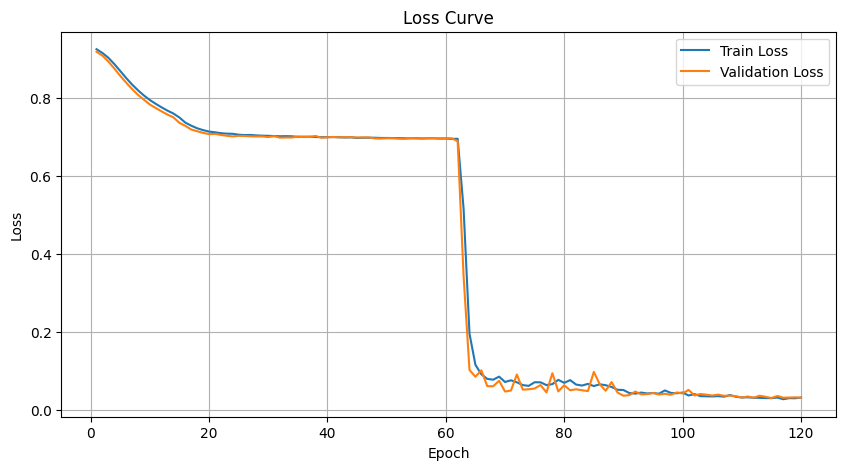

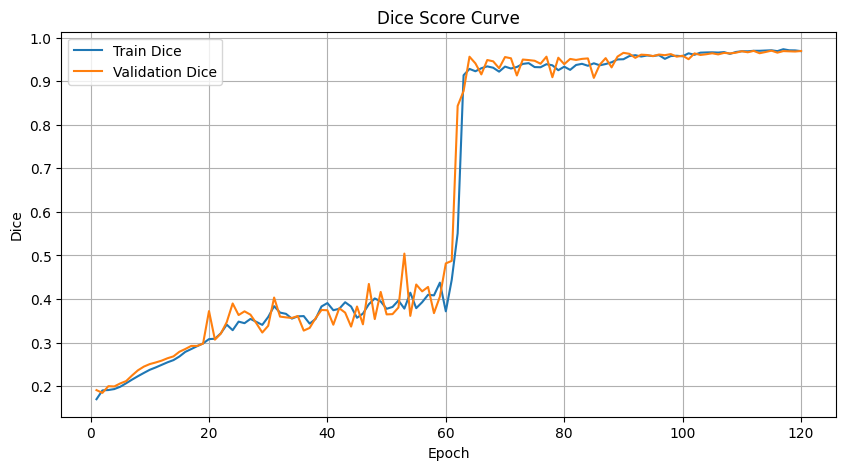

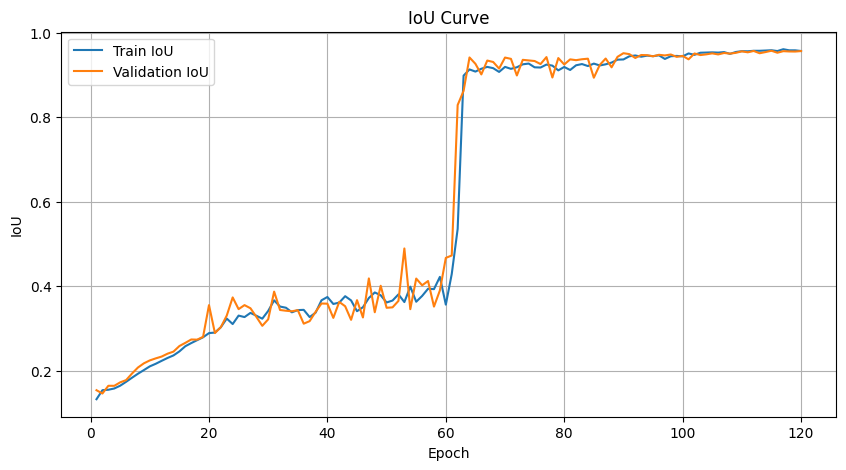

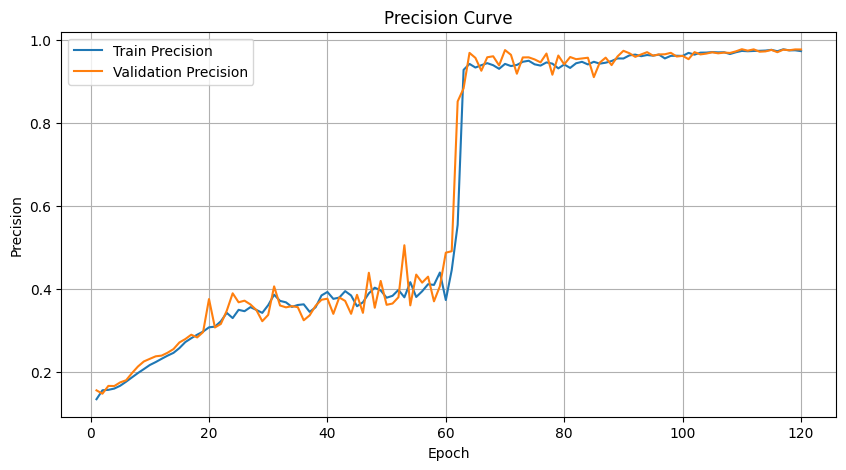

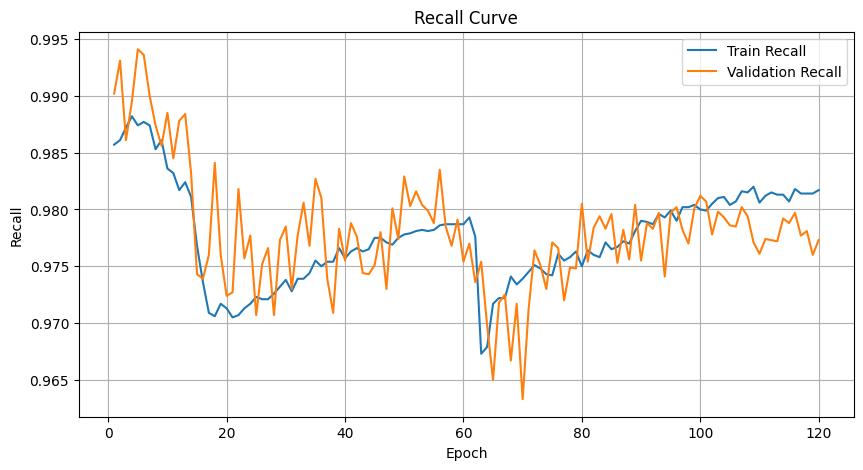

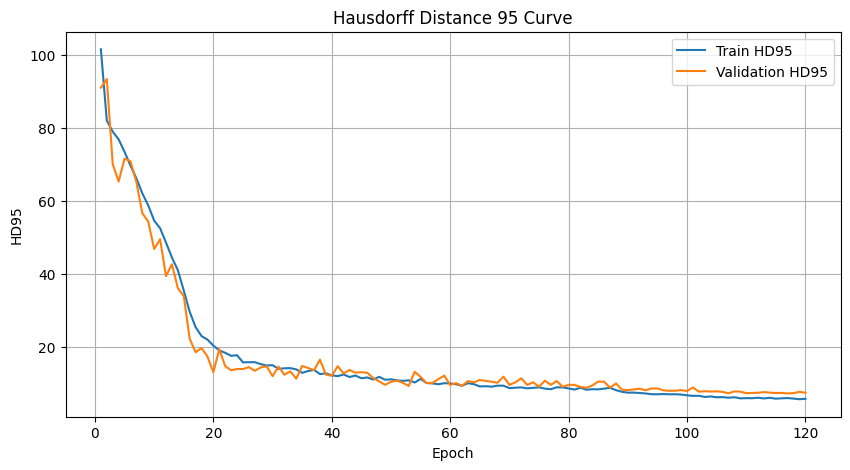

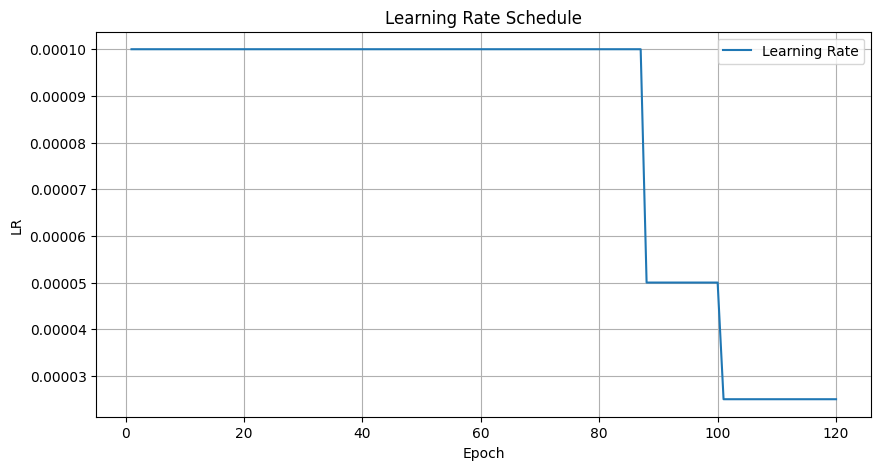

In [25]:
# Plotting training and validation metrics

import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
csv_path = "/kaggle/input/unetmetricsdice/Unet_metrics.csv"
df = pd.read_csv(csv_path)

print(df.head())

# Helper function to plot curves
def plot_curve(df, column_train, column_val, title, ylabel):
    plt.figure(figsize=(10,5))
    plt.plot(df['epoch'], df[column_train], label=f"Train {ylabel}")
    plt.plot(df['epoch'], df[column_val], label=f"Validation {ylabel}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# ---- Plot all metrics ----

# Loss
plot_curve(df, "train_loss", "val_loss", "Loss Curve", "Loss")

# Dice
plot_curve(df, "dice_train", "dice_val", "Dice Score Curve", "Dice")

# mIoU
plot_curve(df, "iou_train", "iou_val", "IoU Curve", "IoU")

# Precision
plot_curve(df, "precision_train", "precision_val", "Precision Curve", "Precision")

# Recall
plot_curve(df, "recall_train", "recall_val", "Recall Curve", "Recall")

# HD95
plot_curve(df, "hd_train", "hd_val", "Hausdorff Distance 95 Curve", "HD95")

# Learning Rate
plt.figure(figsize=(10,5))
plt.plot(df['epoch'], df['lr'], label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule")
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(



================= FINAL VALIDATION METRICS =================
Dice Score: 0.9702
IoU (mIoU): 0.9572
Precision:  0.9762
Recall:     0.9788
HD95:       7.2955

Found 10 validation samples with liver.


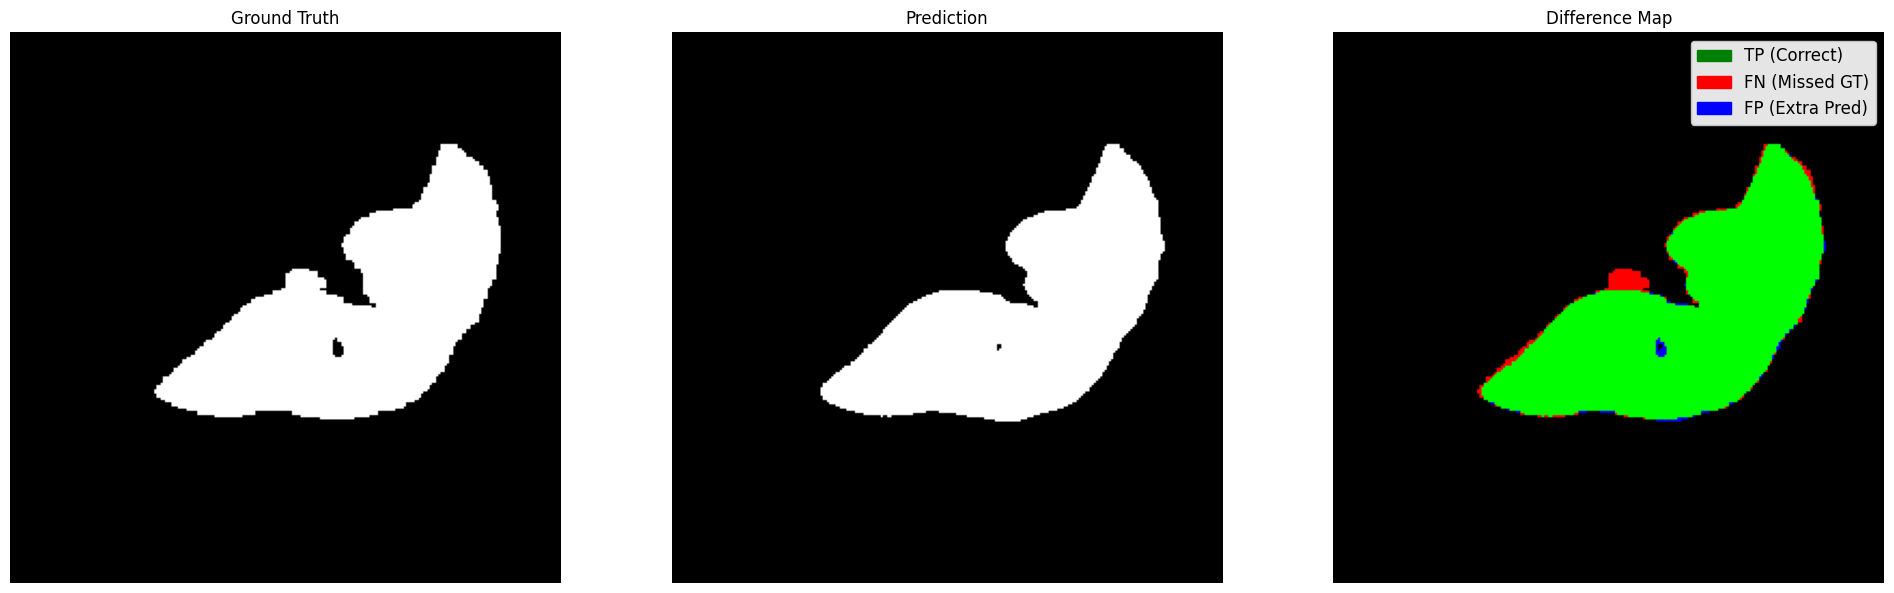

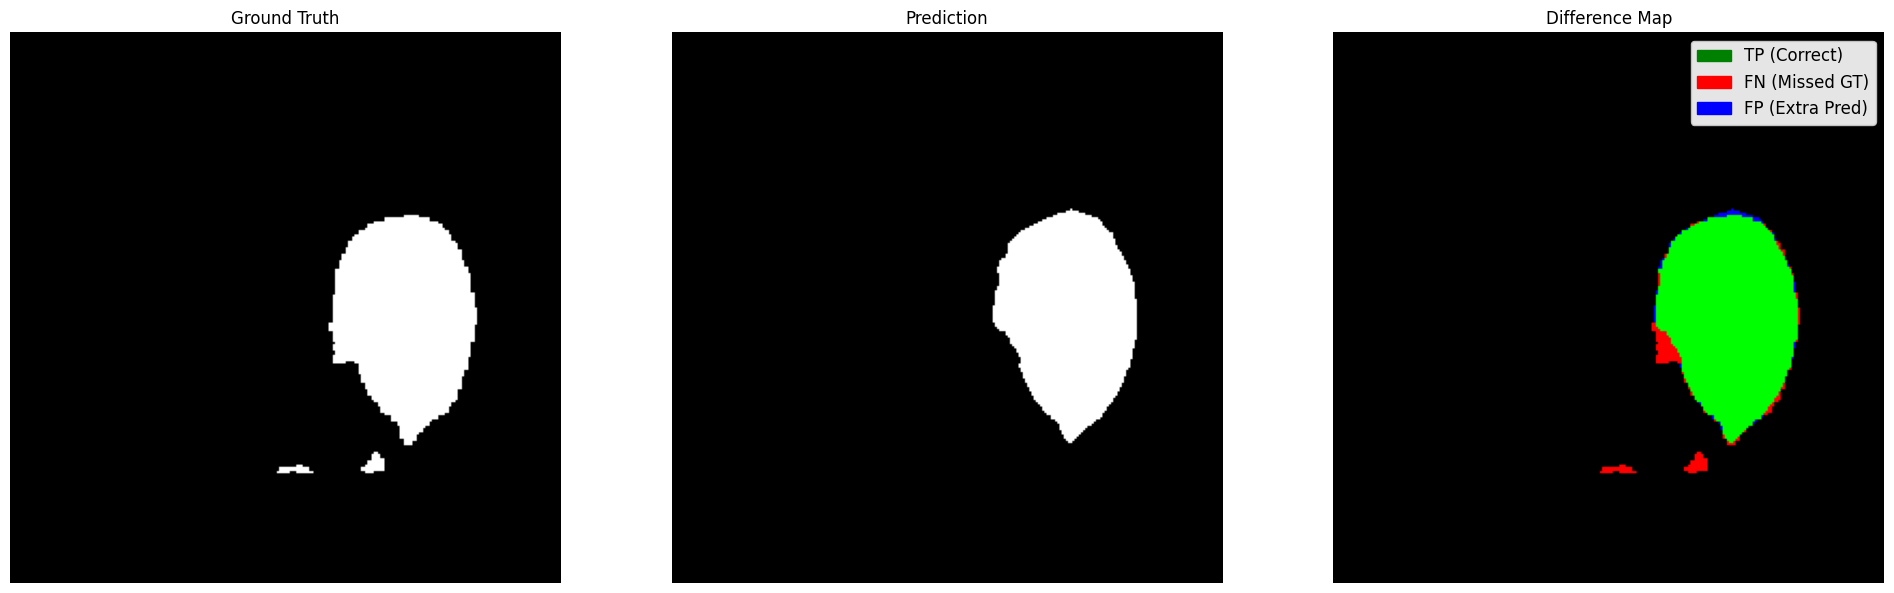

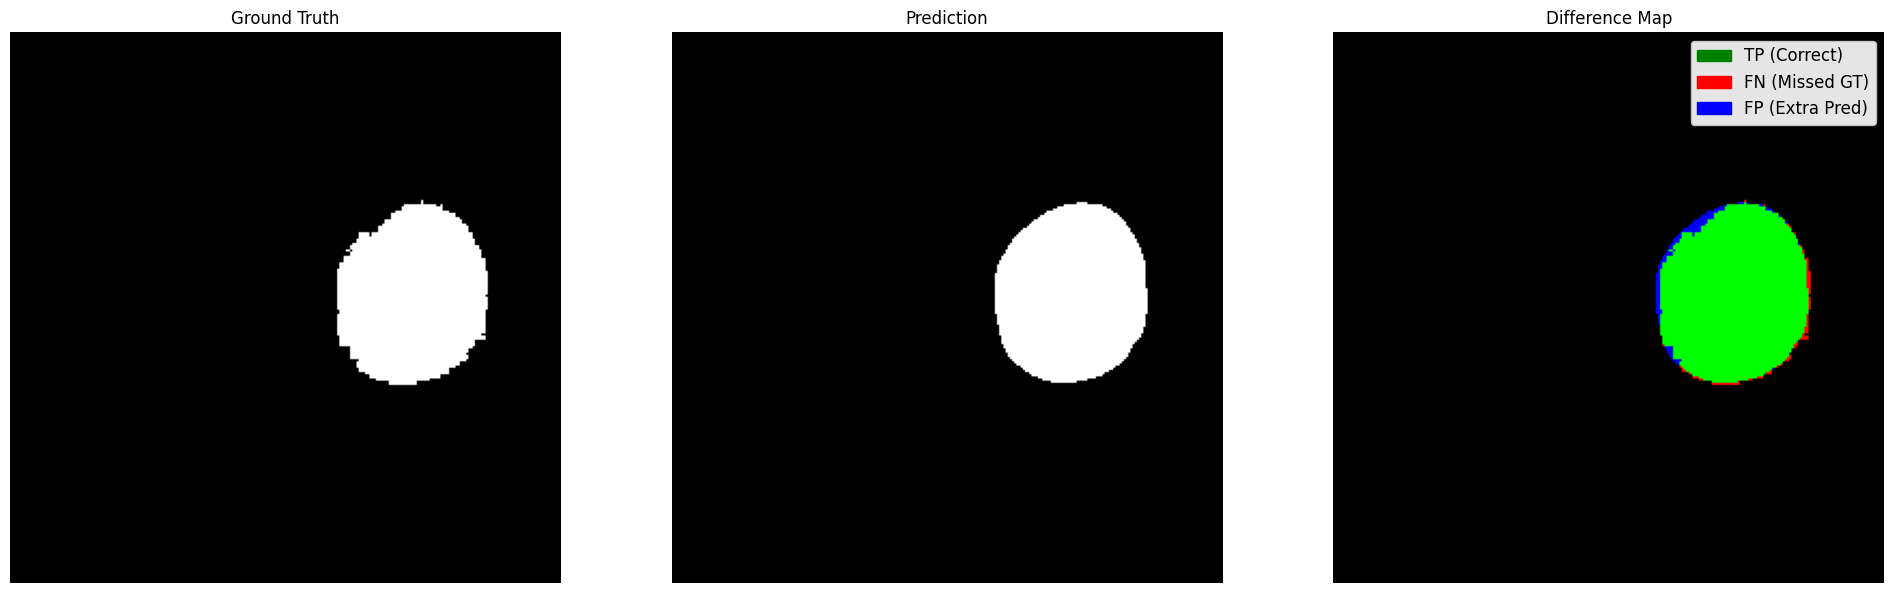

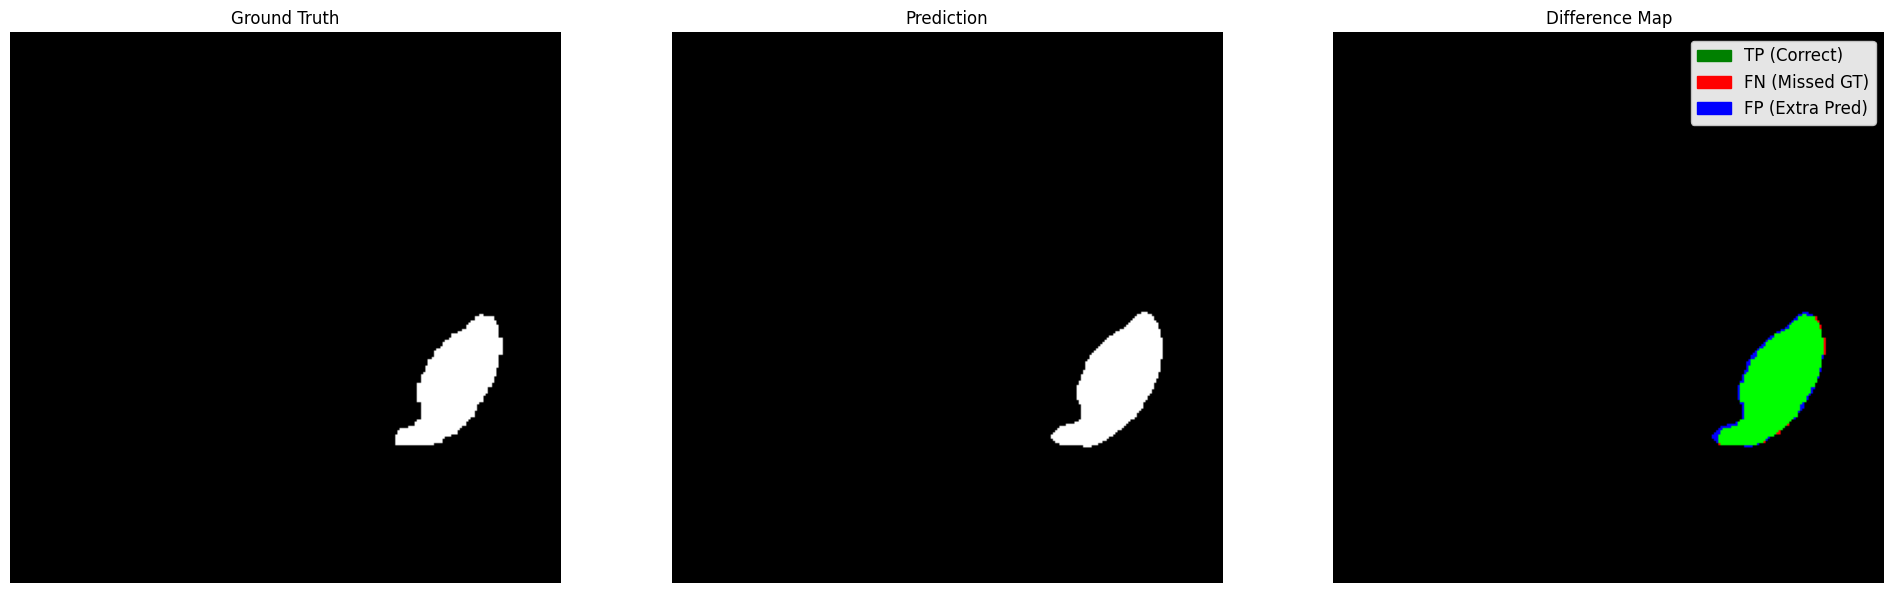

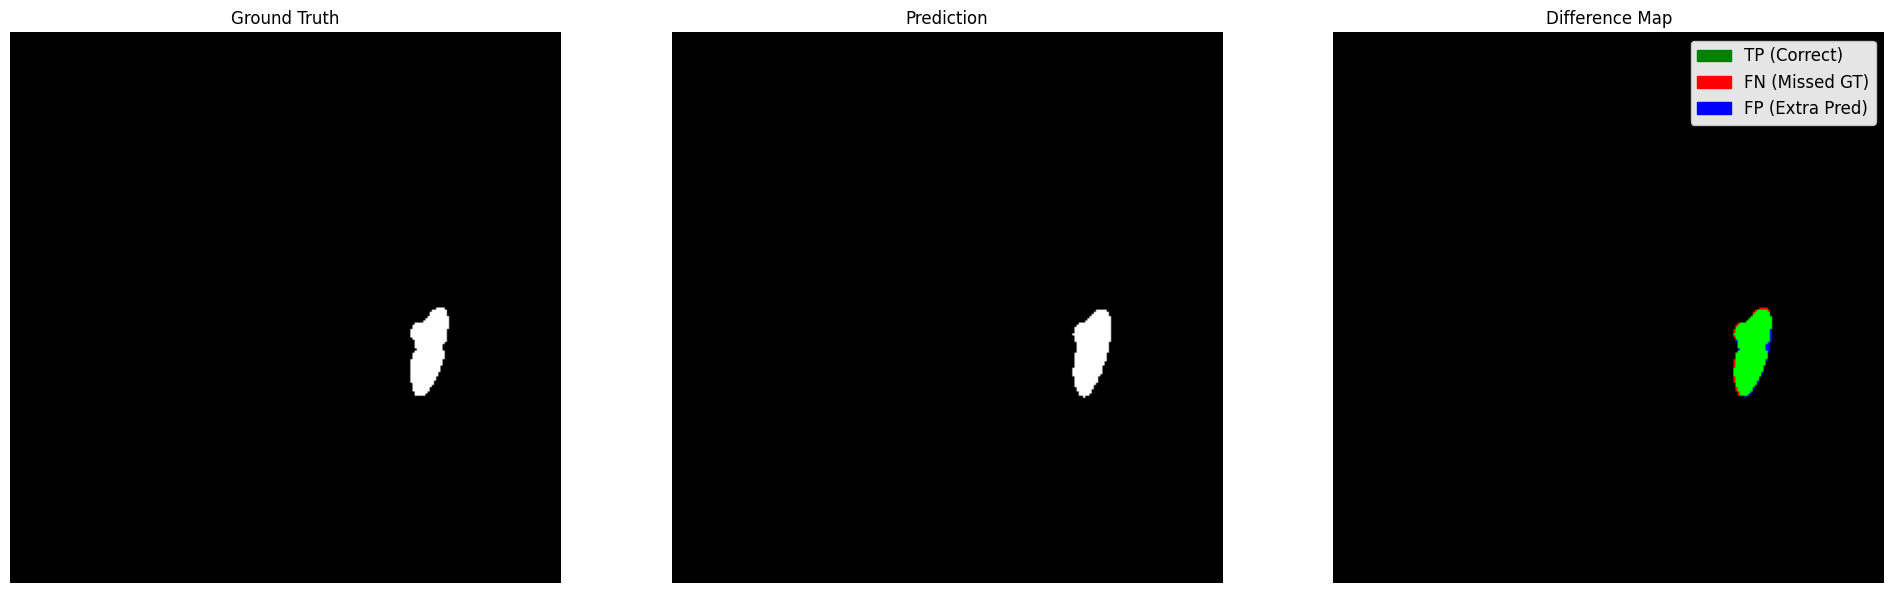

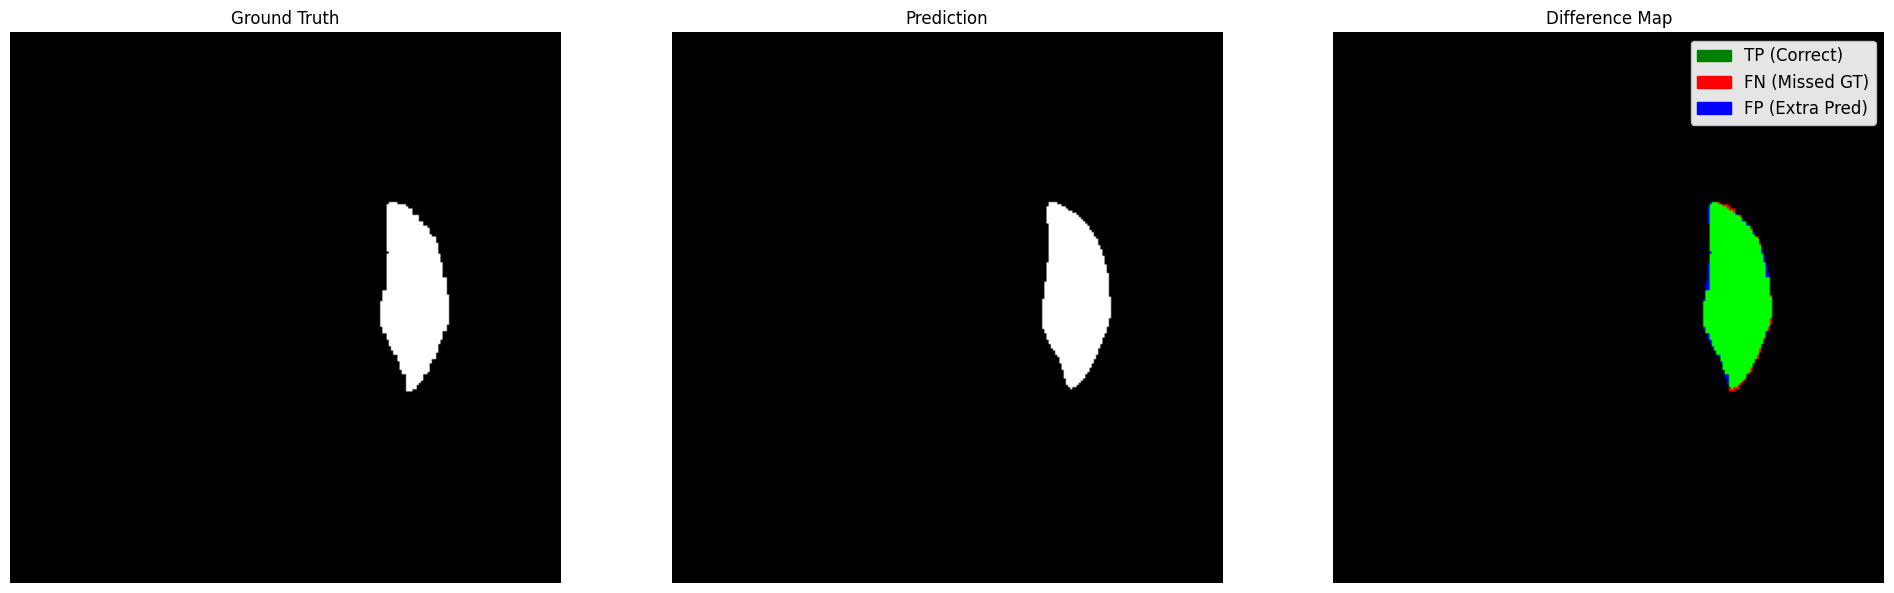

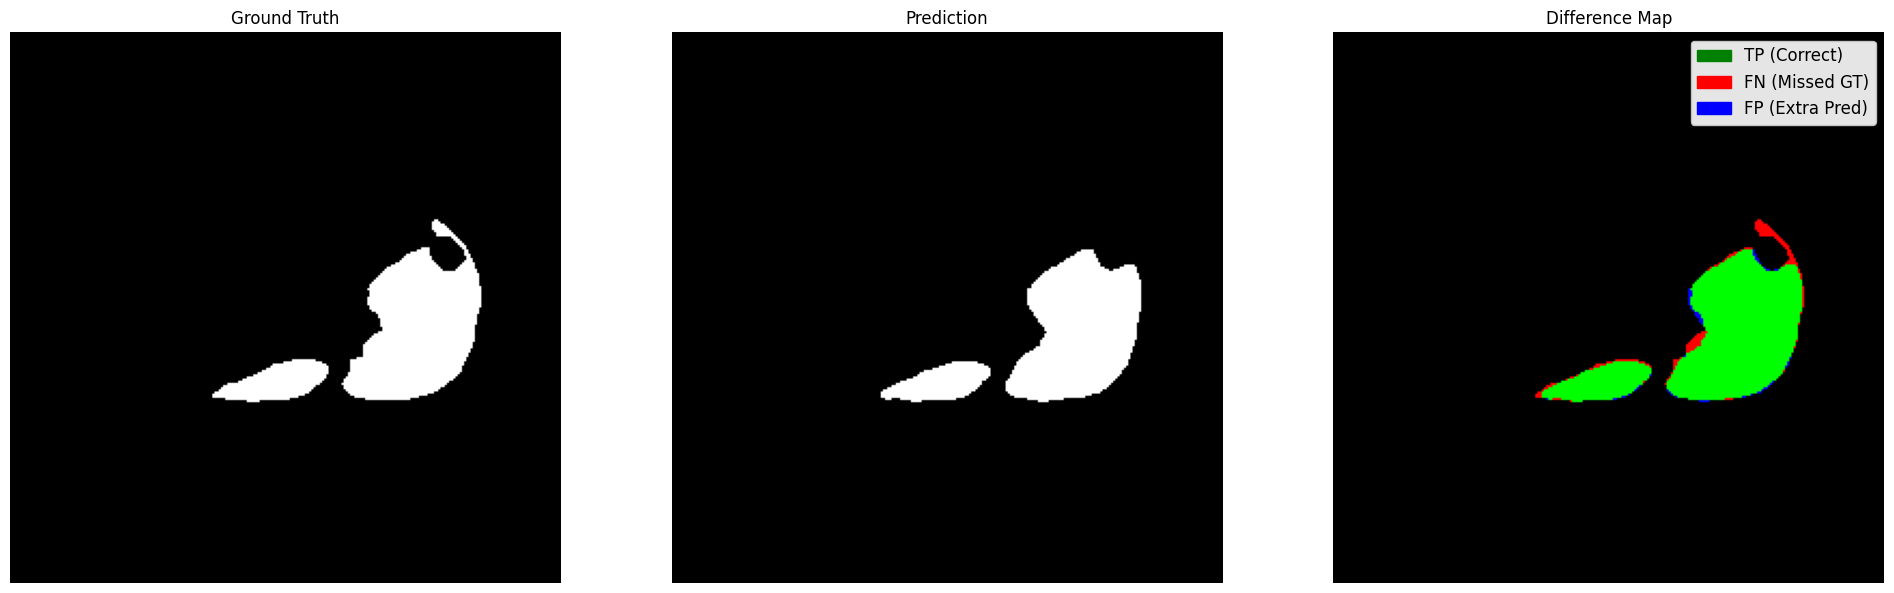

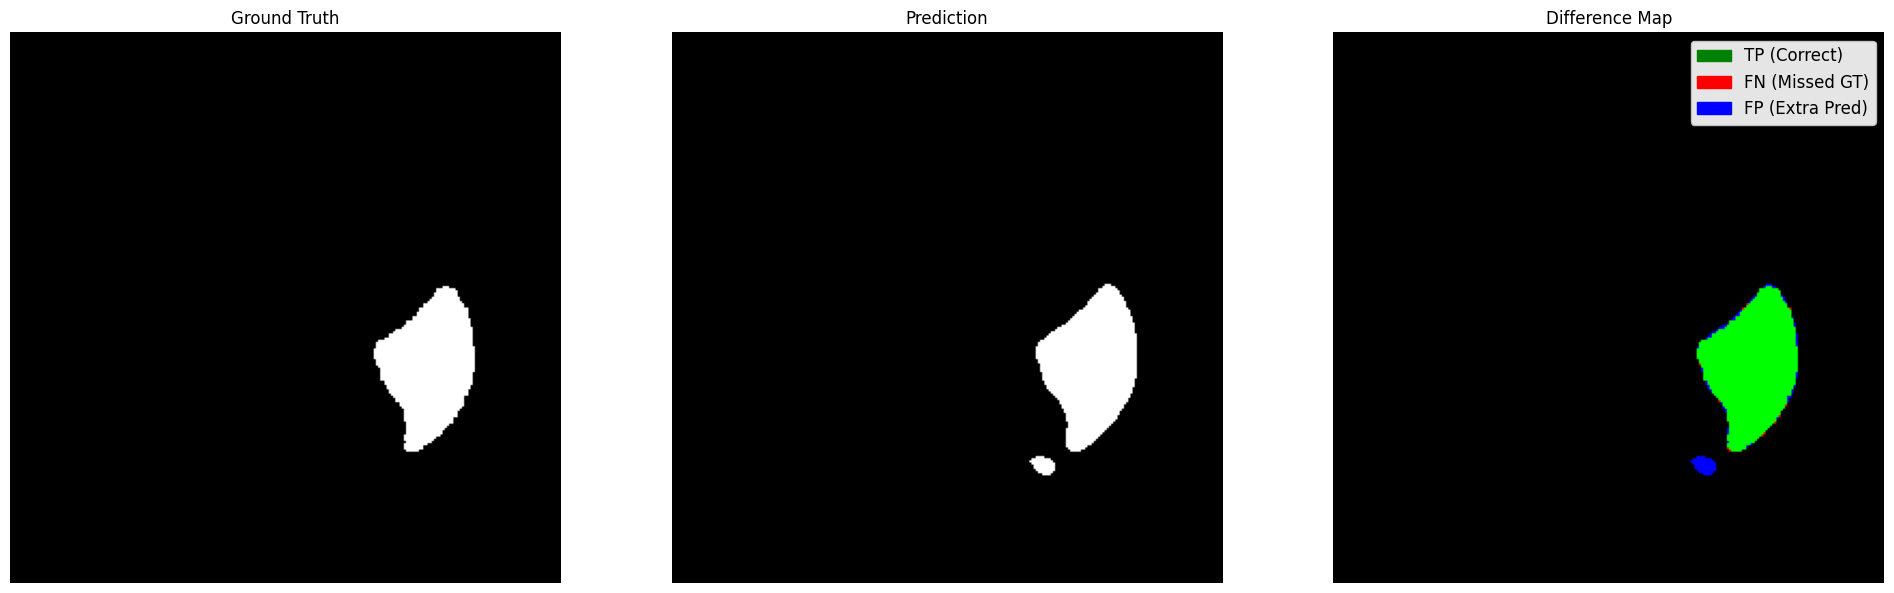

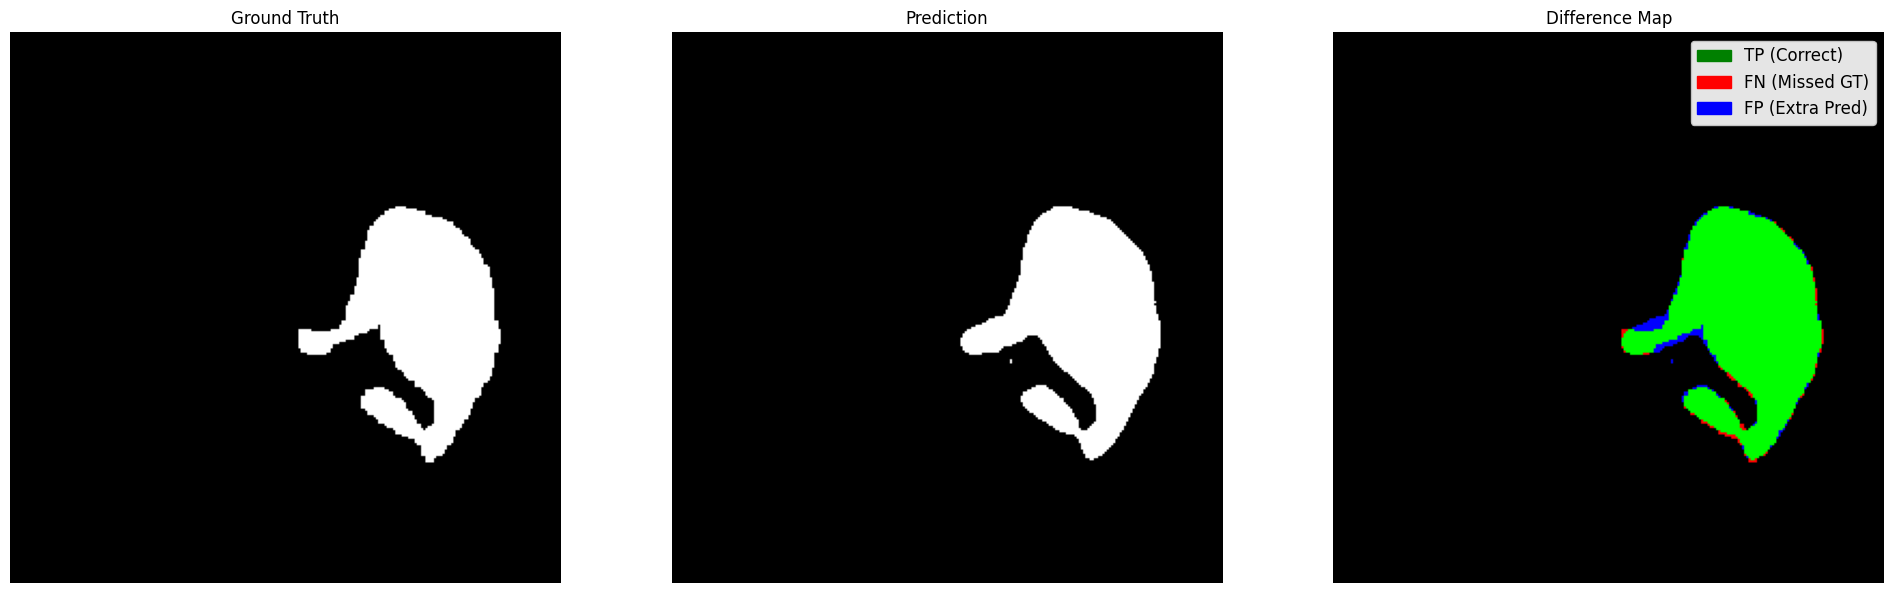

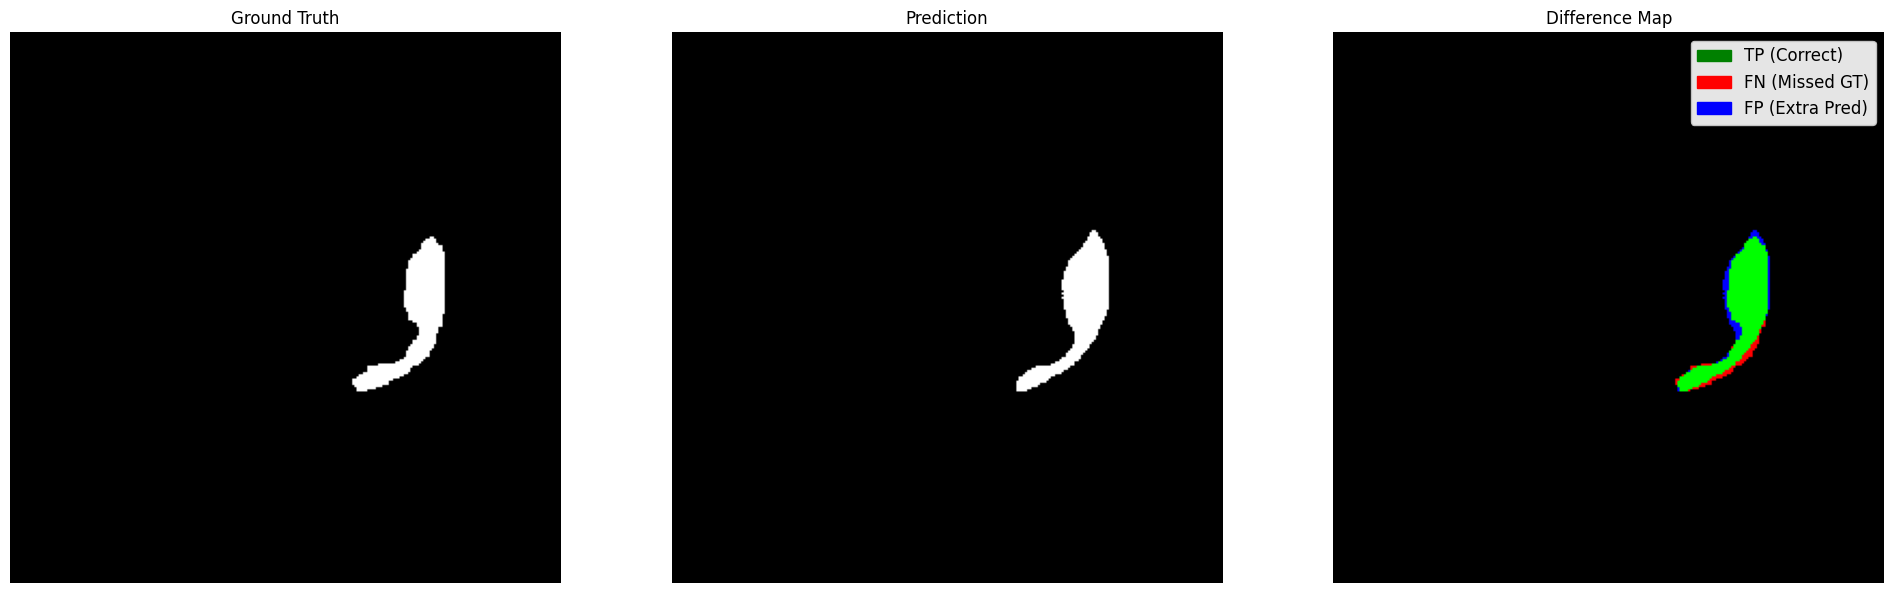

In [26]:

import math
from matplotlib.patches import Patch


model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

model.load_state_dict(torch.load(
    "/kaggle/input/unetdice/pytorch/default/1/Unet_best.pth",
    map_location=device
))
model.eval()

all_dice, all_iou, all_prec, all_rec, all_hd = [], [], [], [], []


with torch.no_grad():
    for batch_img, batch_mask in val_dataloader:

        batch_img = batch_img.to(device)
        batch_mask = batch_mask.to(device)

        logits = model(batch_img)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        b_dice, b_iou, b_prec, b_rec = compute_metrics(
            logits.detach(), batch_mask.detach()
        )

        all_dice.append(b_dice)
        all_iou.append(b_iou)
        all_prec.append(b_prec)
        all_rec.append(b_rec)

        try:
            hd_batch = compute_hausdorff(
                logits.detach().cpu(), batch_mask.detach().cpu()
            )
        except:
            hd_batch = 0.0

        if not isinstance(hd_batch, float) or not math.isfinite(hd_batch):
            hd_batch = 0.0

        all_hd.append(hd_batch)


print("\n================= FINAL VALIDATION METRICS =================")
print(f"Dice Score: {np.mean(all_dice):.4f}")
print(f"IoU (mIoU): {np.mean(all_iou):.4f}")
print(f"Precision:  {np.mean(all_prec):.4f}")
print(f"Recall:     {np.mean(all_rec):.4f}")
print(f"HD95:       {np.mean(all_hd):.4f}")
print("=============================================================\n")



def visualize(gt, pred, diff, idx):

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].imshow(gt, cmap="gray")
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred, cmap="gray")
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    axs[2].imshow(diff)
    axs[2].set_title("Difference Map")
    axs[2].axis("off")

    legend_elements = [
        Patch(facecolor='green', edgecolor='green', label='TP (Correct)'),
        Patch(facecolor='red',   edgecolor='red',   label='FN (Missed GT)'),
        Patch(facecolor='blue',  edgecolor='blue',  label='FP (Extra Pred)')
    ]

    axs[2].legend(
        handles=legend_elements,
        loc='upper right',
        fontsize=12,
        framealpha=0.9
    )

    plt.tight_layout()
    plt.show()



samples = []
for img, mask in val_dataloader:
    for i in range(img.shape[0]):
        if mask[i].sum().item() > 0:
            samples.append((img[i], mask[i]))
        if len(samples) >= 10:
            break
    if len(samples) >= 10:
        break

print(f"Found {len(samples)} validation samples with liver.")


model.eval()
for idx, (img, mask) in enumerate(samples, 1):

    x = img.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        prob = torch.sigmoid(logits)[0,0].cpu().numpy()
        pred = (prob > 0.5).astype(np.uint8)

    gt_vis = mask.numpy().squeeze()
    pred_vis = pred

    diff = np.zeros((gt_vis.shape[0], gt_vis.shape[1], 3), dtype=np.float32)

    diff[(gt_vis == 1) & (pred_vis == 1)] = [0, 1, 0]     # Green
    diff[(gt_vis == 1) & (pred_vis == 0)] = [1, 0, 0]     # Red
    diff[(gt_vis == 0) & (pred_vis == 1)] = [0, 0, 1]     # Blue

    visualize(gt_vis, pred_vis, diff, idx)